In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import geopandas as gpd

In [2]:
# ser: clustered precinct
# tot: total number of ballots
# v: votes

## Initialization

In [3]:
data = pd.read_pickle('contest_res_level_5.p')

senators = data[1]

## Creating matrix of normalized fraction of votes

In [4]:
senators['frac'] = senators['v']/senators['tot'] #taking the fraction of votes of each candidate in each precinct
senators = senators.fillna(0)

In [5]:
sen_num = 62 #total number of senatorial candidates

sen_mat = senators['frac'].values.reshape((senators.shape[0]//sen_num,sen_num))

In [6]:
tot_votes = votes.reshape((senators.shape[0]//sen_num,sen_num))
vote_sum = np.sum(tot_votes,axis=0)

NameError: name 'votes' is not defined

In [ ]:
candidates = ['Villar','Poe','Go','Cayetano','Dela Rosa','Angara','Lapid','Marcos','Tolentino','Pimentel','Bong Revilla','Binay',
              'Ejercito','Aquino','Estrada','Roxas','Osmena','Ong','Mangudadatu','Manicad','Diokno','Enrile','Alejano',
             'Colmenares','Gutoc','Macalintal','Tanada','Gadon','Hilbay','Aguilar','Chong','Alunan','Mangondato','Escudero',
              'Padilla','Arellano','Montano','De Guzman','Chavez','Abejo','Casino','Afuang','Albani','Roleda','Generoso',
              'Sahidulla','Jangao','Arias','Alfajora','Matula','Francisco','Nalliw','Arcega','Valdes','Caceres',
              'Austria','Baldevarona','Mallillin','Gaddi','Javellana','Guigayuma','Meniano']

candidates.sort()

In [ ]:
sorted_results = pd.DataFrame(sen_mat,columns=vote_sum)
cand_list = pd.DataFrame([candidates],columns=vote_sum)
sorted_results = sorted_results.append(cand_list,ignore_index=True)

sorted_votes = np.flip(np.array(sorted_results[sorted(sorted_results)].columns.tolist()))
sorted_results = sorted_results[sorted_votes]

In [ ]:
sorted_results.values[-1]

In [ ]:
# np.savetxt('senators_2019.csv',sorted_results.values[:-1],delimiter=',')

## Plotting Archetypes and Weight Distribution

In [ ]:
def archetype_plots(arc_senators,abundance):    
    weight_sum = [] 
    normalization = []
    pos = np.arange(sen_num) #create array total number of senators

    for n in range(arc_senators.shape[1]): #plotting per archetype
        sorted_arc = arc_senators[n]
        
        peak = max(sorted_arc) #get maximum vote intensity per archetype
        mean = np.mean(sorted_arc) #get mean of vote intensities per archetype
        sigma = np.std(sorted_arc) #get standard deviation of vote intensities per archetype
        
        plt.figure(figsize=(8.5,6))
        
        ax1 = plt.axes()  # standard axes
        ax2 = plt.axes([0.60, 0.625, 0.26, 0.24])
        
        ax1.bar(pos,sorted_arc/peak) #normalize vote intensities
        ax1.axhline((mean+sigma)/peak,color='black',linestyle='--',label='$\mu + \sigma$') #plot the mean+one standard dev line
        ax1.set_xticks(np.arange(0,sen_num+1,5))
        ax1.set_xlabel('candidate',fontsize=14)
        ax1.set_ylabel('intensity',fontsize=14)
        ax1.grid(b=True,axis='both')
        ax1.margins(0.03)
        ax1.legend(loc='lower right')
        
        histogram = np.histogram(peak*abundance[n],bins=40) #plot the weight distribution as an inset
        ax2.bar(histogram[1][:-1],histogram[0]/len(abundance[n]),width=np.diff(histogram[1])[0],color='mediumseagreen')
        ax2.set_ylabel('frequency',fontsize=10)
        ax2.set_xlabel('weights',fontsize=10)
        ax2.set_xticks(np.arange(0,1.2,0.4))
        ax2.set_xlim(0,0.8)
        
#         plt.savefig('archetype_'+str(n+1)+'.png',dpi=600,bbox_inches='tight')
        plt.show()
    
        weight_sum.append(np.sum(abundance[n])) #sum of weights per archetype
        normalization.append(peak) #store the maximum vote intensity per archetype
        
    return weight_sum,normalization

## Looking at endmember signatures for MVSA

In [7]:
MVSA_senators = pd.read_csv('new_MVSA_senators_2019.csv',header=None)
MVSA_votes = np.array(MVSA_senators.sum(axis=1))

MVSA_abundance = pd.read_csv('new_MVSA_abundances_2019.csv',header=None).values

In [8]:
sen_num = 62

In [9]:
weight_sum_MVSA, MVSA_normalization = archetype_plots(MVSA_senators,MVSA_abundance)

NameError: name 'archetype_plots' is not defined

In [ ]:
print('Archetype',np.argmax(weight_sum_MVSA)+1,'has the most weighted sum.')

In [10]:
norm_abundance = np.array(MVSA_normalization)*(MVSA_abundance.T)

NameError: name 'MVSA_normalization' is not defined

## Arrange archetypes according mean of weights

In [8]:
arranged_index = np.flip(np.argsort(np.mean(norm_abundance.T,axis=1))) #calculate the weights mean of each archeytpe

In [9]:
MVSA_2016 = np.copy(MVSA_senators.T)
counter = 0

#arrange archetype sigantures based on obtained indices
for i in arranged_index:
    MVSA_2016[counter] = MVSA_senators.values.T[i]
    counter += 1

In [10]:
#save the arranged archetype signatures into a new .csv file
# np.savetxt('MVSA_2016.csv',MVSA_2016,delimiter=',')

In [11]:
#do the same for weights
arranged_abundance = np.copy(norm_abundance.T)
counter = 0

for i in arranged_index:
    arranged_abundance[counter] = norm_abundance.T[i]
    counter += 1

In [12]:
province_map = gpd.read_file('Provinces.shp') #shapefile for province map of the Philippines

In [13]:
prov_names = province_map['PROVINCE'].str.upper().values #province names

In [14]:
ballot_count = np.load('ballot_count.npy')
disregard = np.where(ballot_count==0)[0]
new_ballot_count = np.delete(ballot_count,disregard)

# Determining dominant archetype for each province

In [16]:
def prov_weight(weights,tot_votes):
    #multiply the weights by the total ballot count to account for precincts with higher voting population
    weights = tot_votes*weights  
    
    arc_mean = np.mean(weights,axis=1)
    arc_median = np.median(weights,axis=1)
    
    #return the index of the archetype with the highest mean and median
    return np.argmax(arc_mean)+1,np.argmax(arc_median)+1

# Dominant archetype per province

In [17]:
provinces = np.load('precinct_province.npy')
provinces = np.delete(provinces,disregard)

#province labels in Philippine map shapefile don't match the labels in the election data
provinces[(provinces == 'NATIONAL CAPITAL REGION - FOURTH DISTRICT') | (provinces == 'NATIONAL CAPITAL REGION - SECOND DISTRICT') | 
          (provinces == 'NATIONAL CAPITAL REGION - THIRD DISTRICT') | (provinces == 'NATIONAL CAPITAL REGION - MANILA')] = 'METROPOLITAN MANILA'
provinces[provinces == 'DAVAO (DAVAO DEL NORTE)'] = 'DAVAO DEL NORTE'
provinces[provinces == 'SAMAR (WESTERN SAMAR)'] = 'SAMAR'
provinces[provinces == 'COTABATO (NORTH COT.)'] = 'NORTH COTABATO'
prov_names[prov_names == 'SHARIFF KABUNSUAN'] = 'MAGUINDANAO'

In [18]:
province_index = [] #index of precincts per province

#group the clustered precincts based on province
for p in prov_names:
    province_index.append(np.where(provinces == p)[0])

In [19]:
dom_mean_arc = []
dom_median_arc = []

#calculate the dominant archetype per province
for m in range(len(prov_names)):

    prov_weights = arranged_abundance.T[province_index[m]] #weights corresponding to each province
    total_v = new_ballot_count[province_index[m]] #ballot counts per precinct in each province

    dom_mean,dom_median = prov_weight(np.array(prov_weights).T,total_v) #determine the dominant archetype using function

    dom_mean_arc.append('archetype '+str(dom_mean))
    dom_median_arc.append('archetype '+str(dom_median))

In [21]:
#store the dominant archetype corresponding to each province in the map
province_map['dom_mean_arc'] = dom_mean_arc 
province_map['dom_median_arc'] = dom_median_arc

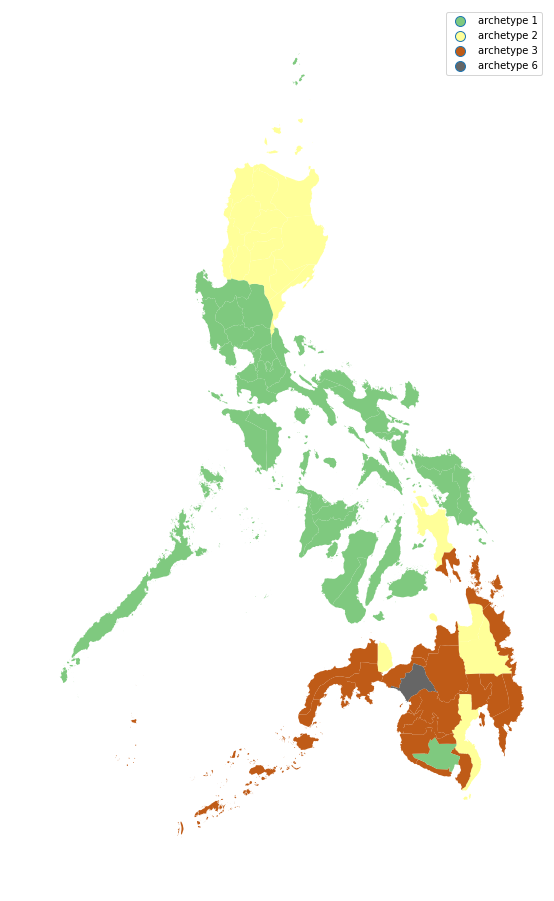

In [30]:
color = plt.get_cmap('Accent',6)
province_map.plot(column='dom_mean_arc',cmap=color,figsize=(18,16),legend=True)
# plt.title('Dominant Archetype by Mean',fontsize=24)
plt.axis('off')
# plt.savefig('2019_map_mean.png',bbox_inches='tight',dpi=600)
plt.show()

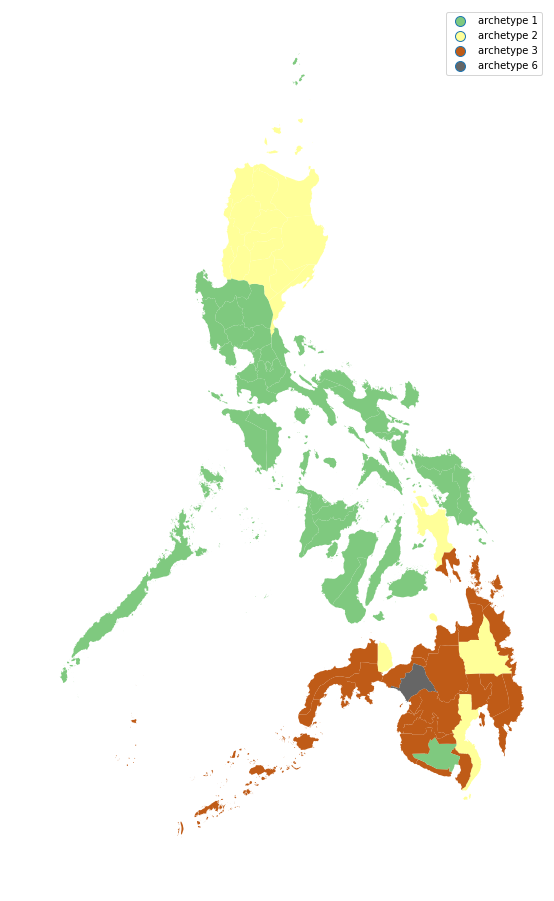

In [31]:
color = plt.get_cmap('Accent',6)
province_map.plot(column='dom_median_arc',cmap=color,figsize=(18,16),legend=True)
# plt.title('Dominant Archetype by Median',fontsize=24)
plt.axis('off')
# plt.savefig('2019_map.png',bbox_inches='tight',dpi=300)
plt.show()